## Retentostat regression model

Based on the regression model from Rebnegger et al 2016, but with the modifications and extensions described in this current study. See RegressionFuncs.py for the actual model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from RegressionFuncs import *
from matplotlib.ticker import MaxNLocator
import os

max_processes = 25
threadpoolctl.threadpool_limits(limits=max_processes)

os.makedirs("../results/dataframes/cultivation_data", exist_ok=True)

In [2]:
Yps_max = 0.609

all_results = []
all_sp_results = []
all_stats = []

# %% Read data from excelfile
filename = 'AllRetentostatData.xlsx'#;
for sheet_name in ["C023","C024", "C030"]:
    
    cult_data = pd.read_excel(f"../data/{filename}", sheet_name=sheet_name).iloc[1:13,1:8]
    cult_data.columns = cult_data.iloc[0]
    cult_data.drop(cult_data.index[0], inplace=True)
    
    
    TIME_LAB_V, CX_VIAB, CX_LAB_std_V, DW, DW_std, TIME_CSin, CS_in_LAB = [x.reshape(-1,1).astype(np.float64) for x in cult_data.T.values]
    mask = DW_std < 1e-2
    DW_std[mask] = DW[mask] * 0.01
    CX_LAB_std_V[mask] = DW_std[mask]*(CX_VIAB[mask]/DW[mask])

    reactor_data = pd.read_excel(f"../data/{filename}", sheet_name=sheet_name).iloc[1:4,9:]
    reactor_data.columns = ["Parameter", "Value", "Description"]
    reactor_data = reactor_data.set_index("Parameter")["Value"]
    V_A, V_B, Fin_A = [np.array([[x]]) for x in reactor_data.values]
    Fin_A = Fin_A/1000

    
    qp_data = pd.read_excel(f"../data/qp_Cp_Retentostat.xlsx", sheet_name=sheet_name)
    chem = pd.read_excel(f"../data/qp_Cp_Retentostat.xlsx", sheet_name="Sheet1")
    chem_mu = chem["mu (h-1)"].values
    chem_qp = chem["qP"].values

    qp_mu = qp_data["mu (h-1)"].values
    ac_cp = qp_data["Accumulated CP"].values
    qp_qp = qp_data["qP"].values/1000
    
    
    all_mu = np.concatenate([qp_mu, chem_mu])
    all_qp = np.concatenate([qp_qp, chem_qp])
    
    
    productivity = qp_data.iloc[[0,1,2,6,8,10,14,17,20,24,28],:]
    

    
    prod_func = ProteinProductionFunc(productivity["time (h)"].values, productivity["CP measured (mg/L)"].values, 4)
   
    VIABILITY = CX_VIAB/ DW
    TIME_LAB_h = 24*TIME_LAB_V
    death_func = GenerateDeathFunction(TIME_LAB_h, VIABILITY, 3)
    
    regression_results, stats_series = retentostat_regression(TIME_CSin, CS_in_LAB, Fin_A, V_A, V_B, CX_VIAB, TIME_LAB_V, 
                                                              CX_LAB_std_V, DW, DW_std, Yps_max, prod_func, death_func)
                                                                 
    
    regression_results["Cultivation"] = sheet_name
    all_results.append(regression_results)
    stats_series.name = sheet_name
    all_stats.append(stats_series)
    
    sp_result = regression_results[regression_results["Time d"].isin(TIME_LAB_V.flatten())].copy()
    
    sp_name = [f"R{i}" for i in np.arange(11)]
    sp_name[0] = "SS"
    sp_result["Sample Point"] = sp_name
    all_sp_results.append(sp_result)
    
    # plot_regression_model(regression_results, TIME_LAB_V, CS_in_LAB, stats_series, DW, CX_VIAB, productivity, sheet_name)
    
df_stats = pd.concat(all_stats, axis=1).T
df_stats.to_csv("../results/dataframes/cultivation_data/StatsDynamicRetentostat.csv")

df_results = pd.concat(all_results)
df_results.to_csv("../results/dataframes/cultivation_data/RegressionDynamicRetentostat.csv", index=False)

sc_results = df_results[df_results.Cultivation.isin(["C023", "C024", "C030"])]
sc_results.to_csv("../results/dataframes/cultivation_data/SCRegressionDynamicRetentostat.csv", index=False)

df_sp_results = pd.concat(all_sp_results)
df_sp_results.to_csv("../results/dataframes/cultivation_data/SamplePointsDynamicRetentostat.csv", index=False)


x^0 =   3.6375e-03 ± 7.6e-09
x^0 =   3.7646e-03 ± 1.0e-08
x^0 =   3.5469e-03 ± 8.4e-09


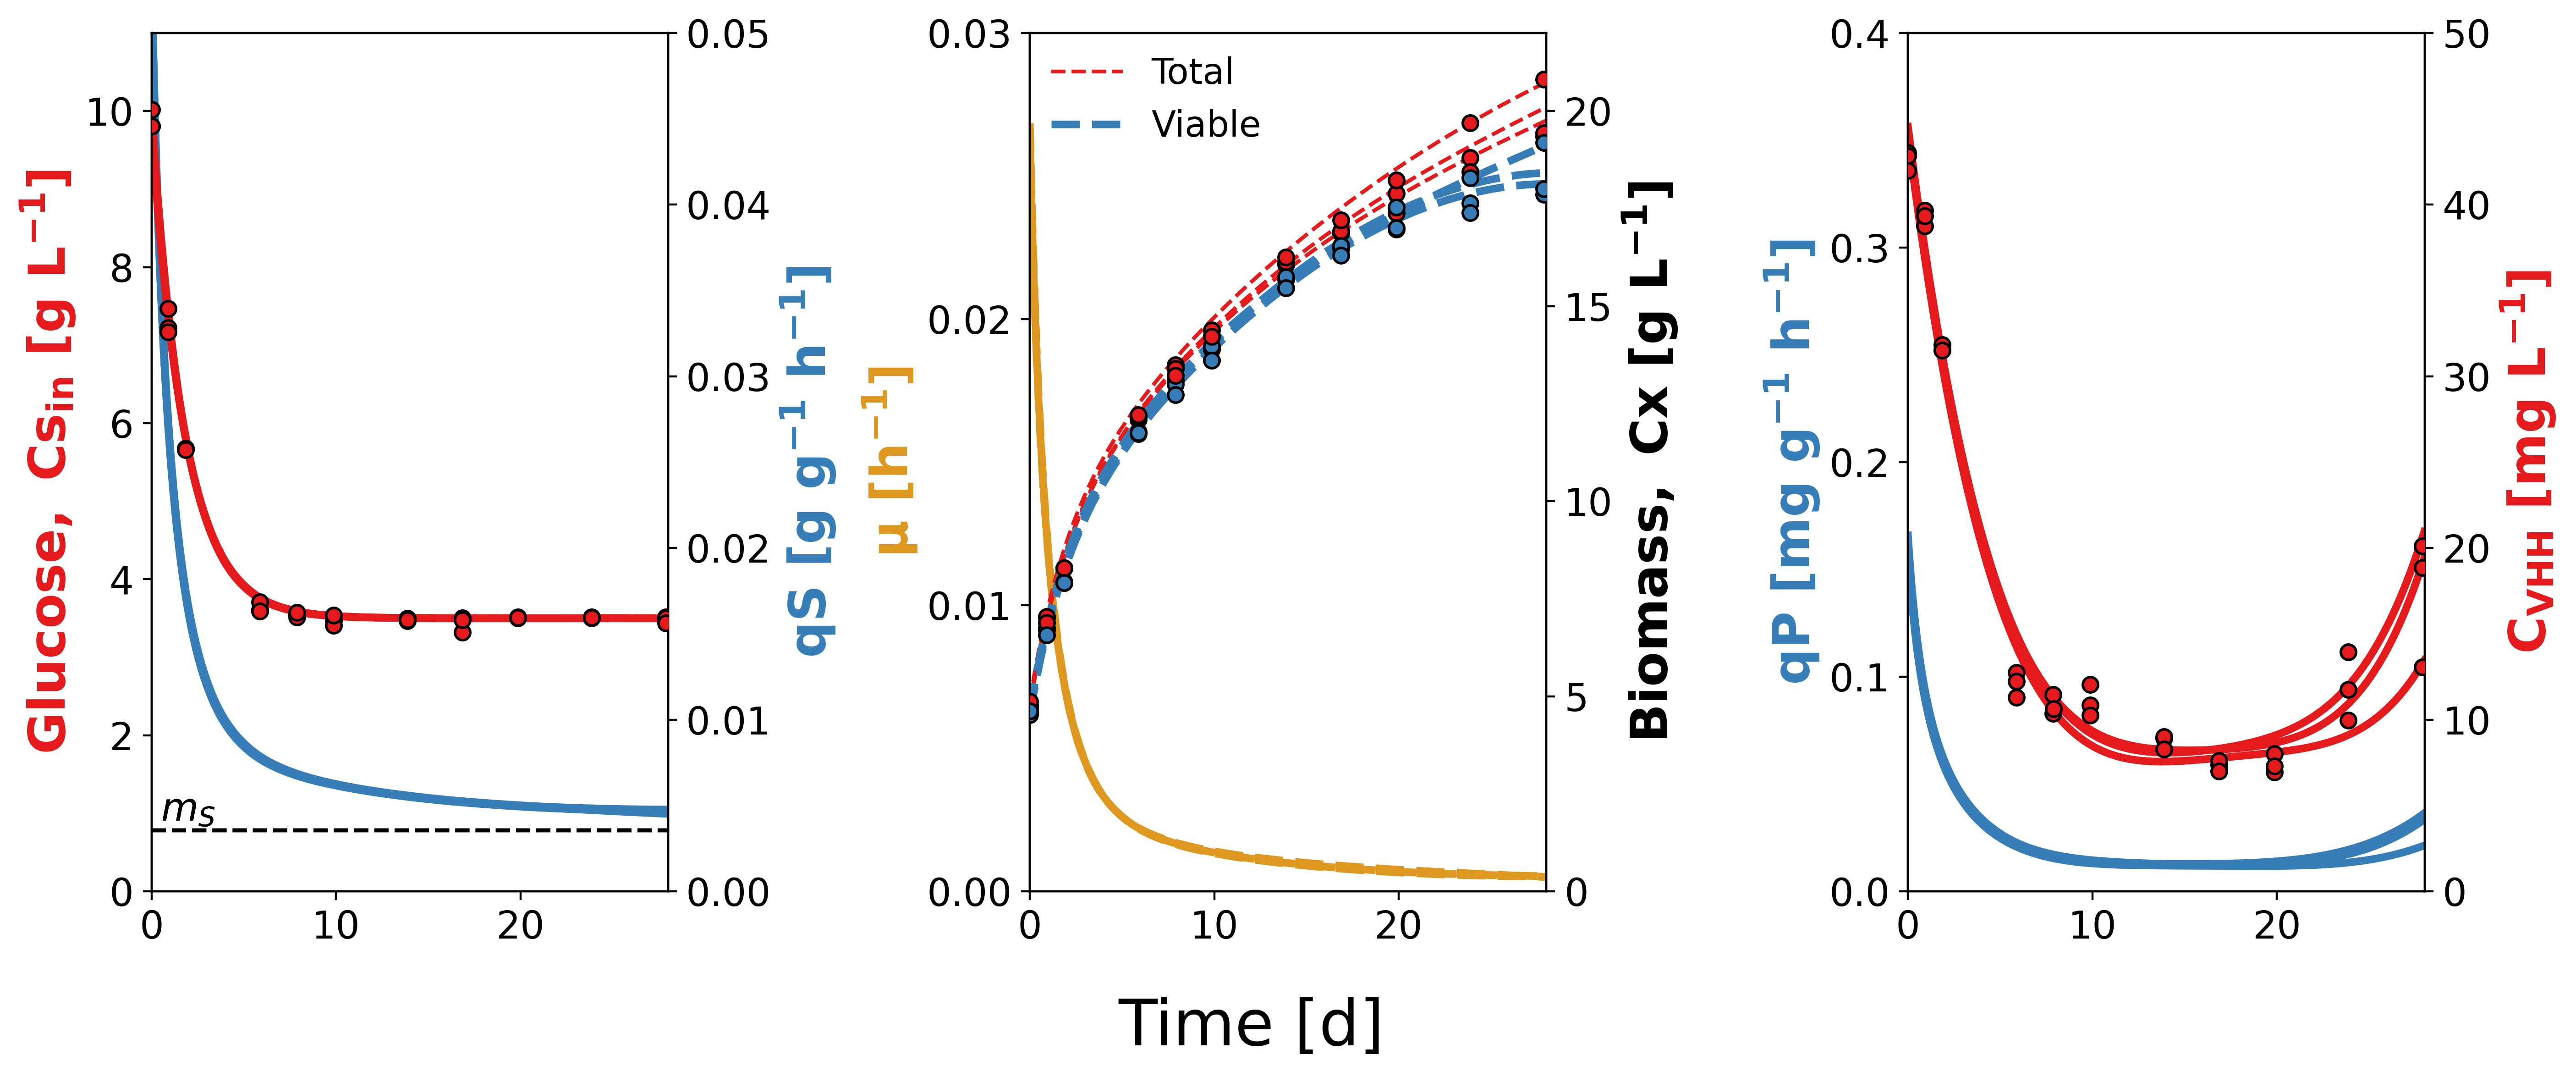

In [3]:
temp = df_results.set_index("Cultivation")
cultivation = temp.index.unique()

    
fig = plt.figure(figsize=(16, 6), dpi=400)
spec = fig.add_gridspec(1, 1, wspace=0.8, bottom=0.1)

gssub = spec[0].subgridspec(1, 3)
ax1 = fig.add_subplot(gssub[0, 0])

ax2 = ax1.twinx()
ax3 = fig.add_subplot(gssub[0, 1])

ax4 = ax3.twinx()
ax5 = fig.add_subplot(gssub[0, 2])

ax6 = ax5.twinx()

fig.text(0.5, -0.04, 'Time [d]', ha='center', fontsize=25)
    
for cul in temp.index.unique():
    
    cult_data = pd.read_excel(f"../data/{filename}", sheet_name=cul).iloc[1:13,1:8]

    cult_data.columns = cult_data.iloc[0]
    cult_data.drop(cult_data.index[0], inplace=True)
    TIME_LAB_V, CX_VIAB, CX_LAB_std_V, DW, DW_std, TIME_CSin, CS_in_LAB = [x.reshape(-1,1).astype(np.float64) for x in cult_data.T.values]
    mask = DW_std < 1e-2
    DW_std[mask] = DW[mask] * 0.01
    CX_LAB_std_V[mask] = DW_std[mask]*(CX_VIAB[mask]/DW[mask])

    reactor_data = pd.read_excel(f"../data/{filename}", sheet_name=cul).iloc[1:4,9:]
    reactor_data.columns = ["Parameter", "Value", "Description"]
    reactor_data = reactor_data.set_index("Parameter")["Value"]
    V_A, V_B, Fin_A = [np.array([[x]]) for x in reactor_data.values]
    Fin_A = Fin_A/1000

    
    qp_data = pd.read_excel(f"../data/qp_Cp_Retentostat.xlsx", sheet_name=cul)
    chem = pd.read_excel(f"../data/qp_Cp_Retentostat.xlsx", sheet_name="Sheet1")
    chem_mu = chem["mu (h-1)"].values
    chem_qp = chem["qP"].values

    qp_mu = qp_data["mu (h-1)"].values
    ac_cp = qp_data["Accumulated CP"].values
    qp_qp = qp_data["qP"].values/1000
    
    
    all_mu = np.concatenate([qp_mu, chem_mu])
    all_qp = np.concatenate([qp_qp, chem_qp])
    
    
    productivity = qp_data.iloc[[0,1,2,6,8,10,14,17,20,24,28],:]
    
    prod_func = ProteinProductionFunc(productivity["time (h)"].values, productivity["CP measured (mg/L)"].values, 4)
   
    VIABILITY = CX_VIAB/ DW
    TIME_LAB_h = 24*TIME_LAB_V
    death_func = GenerateDeathFunction(TIME_LAB_h, VIABILITY, 3)
    
    
    regression_results = temp.loc[cul,:]
    ax1.plot(regression_results["Time d"], regression_results["Cs g/L"], c="#e41a1c", lw=3)
    ax1.scatter(TIME_LAB_V.flatten(),CS_in_LAB.flatten(), facecolors="#e41a1c", edgecolors="black", zorder=10)
    # ax1.set_ylabel('$Glucose,\ Cs_{in}\ [g\ L^{-1}]$', fontsize=15,labelpad=3, c="#e41a1c",fontweight="bold")
    ax1.set_ylabel('$\mathbf{Glucose,\ Cs_{in}\ [g\ L^{-1}]}$', fontsize=20,labelpad=3, c="#e41a1c",fontweight="bold")
    ax1.set_ylim(0, 11)
    ax1.set_yticks([0,2,4,6,8,10])

    ax2.plot(regression_results["Time d"], regression_results["qS model g/gh"], c="#377eb8" ,lw=3)
    ax2.hlines(stats_series[0]/1000, 0, 30, colors="black", linestyles="--")
    ax2.text(0.5, 3.649/1000, '$m_S$', 
        horizontalalignment='left',
        verticalalignment='bottom', 
        fontsize=15)
    # ax2.set_ylabel('$qS\ [g\ g^{-1} h^{-1}]$', fontsize=15,labelpad=3, c="#377eb8",fontweight="bold")
    ax2.set_ylabel('$\mathbf{qS\ [g\ g^{-1}\ h^{-1}]}$', fontsize=20,labelpad=3, c="#377eb8",fontweight="bold")
    ax2.set_ylim(0, 0.05)
    ax2.set_yticks([0,0.01, 0.02, 0.03, 0.04, 0.05])
    
    ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
    ax1.patch.set_visible(False)

    ax3.plot(regression_results["Time d"], regression_results["Growth Rate model 1/h"], c="#de981f", linestyle="dashed", lw=3)
    # ax3.set_ylabel('$\mu\ [h^{-1}]$', fontsize=15,labelpad=3, c="#de981f",fontweight="bold") #c="#4daf4a")
    ax3.set_ylabel('$\mathbf{\mu\ [h^{-1}]}$', fontsize=20,labelpad=3, c="#de981f",fontweight="bold") #c="#4daf4a")
    ax3.set_ylim(0, 0.03)
    ax3.set_yticks([0, 0.01, 0.02, 0.03])
    
    ax4.plot(regression_results["Time d"], regression_results["Biomass model g/L"], c="#e41a1c", lw=1.5, label="Total", linestyle="--")
    ax4.scatter(TIME_LAB_V.flatten(),DW.flatten(),  facecolors="#e41a1c", edgecolors="black", zorder=10)
    # ax4.set_ylabel('$Biomass,\ Cx\ [g\ L^{-1}]$', fontsize=15,labelpad=3,fontweight="bold")#, c="#e41a1c")
    ax4.set_ylabel('$\mathbf{Biomass,\ Cx\ [g\ L^{-1}]}$', fontsize=20,labelpad=3,fontweight="bold")

    ax4.plot(regression_results["Time d"], regression_results["Biomass viable model g/L"], c="#377eb8" , lw=3, label="Viable", linestyle="--")
    ax4.scatter(TIME_LAB_V.flatten(),CX_VIAB.flatten(), facecolors="#377eb8", edgecolors="black", zorder=10)
    
    ax4.set_ylim(0, 22)
    ax4.set_yticks([0,5,10,15,20])

    ax5.plot(regression_results["Time d"], regression_results["qP model mg/gh"], c="#377eb8" , lw=3)
    # ax5.set_ylabel('$qP\ [mg\ g^{-1} h^{-1}]$', fontsize=15,labelpad=3, c="#377eb8" ,fontweight="bold")
    ax5.set_ylabel('$\mathbf{qP\ [mg\ g^{-1}\ h^{-1}]}$', fontsize=20,labelpad=3, c="#377eb8" ,fontweight="bold")
    ax5.set_ylim(0, 0.4)
    ax5.set_yticks([0,0.1, 0.2, 0.3, 0.4])
    
    ax6.plot(regression_results["Time d"], regression_results["Cp mg/L"], c="#e41a1c", lw=3)
    ax6.scatter(productivity["time (h)"].values/24, productivity["CP measured (mg/L)"].values,  facecolors="#e41a1c", edgecolors="black", zorder=10)
    ax6.set_ylabel('$\mathbf{C_{VHH}\ [mg\ L^{-1}]}$', fontsize=20,labelpad=3, c="#e41a1c",fontweight="black")#extra bold")
    ax6.set_ylim(0, 50)
    ax6.set_yticks([0,10,20,30,40,50])
    

    [x.tick_params(axis='both', which='major', labelsize=15) for x in [ax1,ax2,ax3,ax4,ax5, ax6]]
    # [x.yaxis.set_major_locator(MaxNLocator(5)) for x in [ax1,ax2,ax3,ax4,ax5, ax6]]
    [x.set_xlim(0, 28) for x in [ax1,ax2,ax3,ax4,ax5, ax6]]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
    # plt.xticks(fontsize=50)
    # plt.yticks(fontsize=25)
    
handles, labels = ax4.get_legend_handles_labels()[:2]
handles = handles[:2]
labels = labels[:2]

ax4.legend(handles, labels, loc=2,bbox_to_anchor=(-0.02,1.01), fontsize=14,frameon=False)       
    
fig.savefig(f"../results/plots/RetentostatRegression.png", 
        bbox_inches="tight",  transparent=True)


In [4]:

sc_stats = df_stats[df_stats.index.isin(["C023", "C024", "C030"])]
print(sc_stats["mS opt (mg/g.h)"].mean())
print(sc_stats["mS opt (mg/g.h)"].std())
sc_stats

3.6496870211744152
0.10936959595681171


,mS opt (mg/g.h),mS SD (mg/g.h),SSE,Rsq,Rsq_d,Mu end (h^-1),Doubling time (d),qP at 0 (mg/gh)
C023,3.637545,0.000008,359.176021,0.999753,0.979725,0.000529,54.546861,0.033459
C024,3.764621,0.000010,852.251331,0.999438,0.900945,0.000509,56.785869,0.036359
C030,3.546895,0.000008,963.237080,0.999481,0.998823,0.000502,57.482346,0.021341
